`Note`
In this dataset our desired target for classification task will be **`converted`** variable - has the client signed up to the platform or not.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score

## Data Preparation
* Check if the missing values are presented in the features.
* If there are missing values:

For caterogiral features, replace them with **'NA'**.
For numerical features, replace with with **0.0**

In [62]:
sns.set(style="whitegrid")


In [63]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
df.sample(5, random_state=1)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
719,organic_search,technology,1,NaN,employed,middle_east,2,0.90,0
683,paid_ads,finance,1,47129.0,NaN,south_america,1,0.93,0
503,NaN,education,0,NaN,unemployed,asia,5,0.97,1
424,events,retail,0,64775.0,self_employed,south_america,3,0.70,1
846,social_media,finance,3,46934.0,NaN,australia,3,0.26,1


In [64]:
# Number of missing values, percentage of missing values and data types
pd.DataFrame(
    {
        "missing_values": df.isnull().sum(),
        "missing_%": round(df.isnull().mean() * 100, 2),
        "types": df.dtypes,
    }
)

,missing_values,missing_%,types
lead_source,128,8.76,object
industry,134,9.17,object
number_of_courses_viewed,0,0.00,int64
annual_income,181,12.38,float64
employment_status,100,6.84,object
location,63,4.31,object
interaction_count,0,0.00,int64
lead_score,0,0.00,float64
converted,0,0.00,int64


In [65]:
# List of numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()

# Fill missing values
df[numerical_features] = df[numerical_features].fillna(0)
df[categorical_features] = df[categorical_features].fillna("NA")

In [66]:
# Number of missing values, percentage of missing values and data types
pd.DataFrame(
    {
        "missing_values": df.isnull().sum(),
        "missing_%": round(df.isnull().mean() * 100, 2),
        "types": df.dtypes,
    }
)

,missing_values,missing_%,types
lead_source,0,0.0,object
industry,0,0.0,object
number_of_courses_viewed,0,0.0,int64
annual_income,0,0.0,float64
employment_status,0,0.0,object
location,0,0.0,object
interaction_count,0,0.0,int64
lead_score,0,0.0,float64
converted,0,0.0,int64


In [67]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
# Train, Test, Validation split
full_train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=1)
len(train_df), len(val_df), len(test_df)

(876, 293, 293)

In [68]:
# Prepare data for modeling
target = "converted"
features = numerical_features + categorical_features
features.remove(target)

# Training set
X_train = train_df[features].reset_index(drop=True)
y_train = train_df[target].reset_index(drop=True)

# Validation set
X_val = val_df[features].reset_index(drop=True)
y_val = val_df[target].reset_index(drop=True)

# Test set
X_test = test_df[features].reset_index(drop=True)
y_test = test_df[target].reset_index(drop=True)

## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

~ Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that
  
**If your AUC is < 0.5, invert this variable by putting "-" in front**

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

**Which numerical variable (among the following 4) has the highest AUC?**

* `lead_score`
* `number_of_courses_viewed`
* `interaction_count`
* `annual_income`


In [69]:
# Numerical values to check AUC
numerical = numerical_features.copy()
numerical.remove(target)
print(numerical)

['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [70]:
# Calculate AUC for each numerical feature
for feat in numerical:
    auc = roc_auc_score(y_train, X_train[feat])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feat])
    print(f"{feat:<25}| AUC: {auc:.3f}")

number_of_courses_viewed | AUC: 0.764
annual_income            | AUC: 0.552
interaction_count        | AUC: 0.738
lead_score               | AUC: 0.614


## Question 2: Training the model
Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```
What's the AUC of this model on the validation dataset? (round to 3 digits)

- `0.32`
- `0.52`
- `0.72`
- `0.92`

In [71]:
# One-hot encoding
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(X_train.to_dict(orient="records"))
X_val = dv.transform(X_val.to_dict(orient="records"))

In [72]:
X_train.shape, X_val.shape

((876, 31), (293, 31))

In [73]:
# Logistic Regression
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1_000)
model.fit(X_train, y_train)

# Validation set predictions
y_pred = model.predict_proba(X_val)[:, 1]

# AUC score
auc = roc_auc_score(y_val, y_pred)
print(f"AUC for the validation dataset: {auc:.3f}")

AUC for the validation dataset: 0.817


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [76]:
# Thresholds
thresholds = np.linspace(start=0.0, stop=1.0, num=101)

# Scores
scores = []

# Evaluate thresholds
for t in thresholds:
    # Apply threshol to get binary prediction
    y_val_binary = (y_pred >= t).astype(int)

    # Calculate Precision and Recall
    p = precision_score(y_val, y_val_binary, zero_division=0)
    r = recall_score(y_val, y_val_binary)

    scores.append((t, p, r))

df_scores = pd.DataFrame(scores, columns=["threshold", "precision", "recall"])

# Absolute difference between precision and recall
df_scores["pr_diff"] = np.abs(df_scores["precision"] - df_scores["recall"])

# Find the threshold where this difference is minimal
intersection_threshold = (
    df_scores.query("precision != 0 & recall != 0")
    .sort_values(by="pr_diff")
    .head(1)["threshold"]
    .values[0]
)

print(f"Intersection threshold: {intersection_threshold:.3f}")

Intersection threshold: 0.000


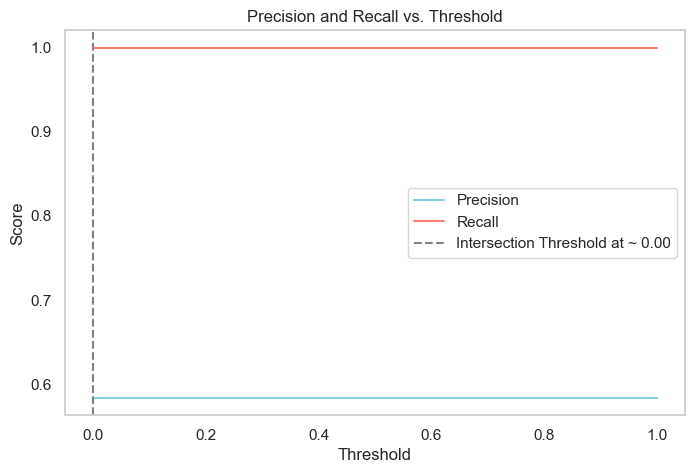

In [78]:
# Precision and Recall plot
plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_scores, x="threshold", y="precision", label="Precision", color="skyblue"
)

sns.lineplot(data=df_scores, x="threshold", y="recall", label="Recall", color="salmon")

plt.axvline(
    x=intersection_threshold,
    color="gray",
    linestyle="--",
    label=f"Intersection Threshold at ~ {intersection_threshold:.2f}",
)

plt.grid(False)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")

plt.legend()
plt.show()

In [80]:
# Thresholds
thresholds = np.linspace(start=0.0, stop=1.0, num=101)

# Scores
scores = []

# Evaluate thresholds
for t in thresholds:
    # Apply threshol to get binary prediction
    y_val_binary = (y_pred >= t).astype(int)

    # Calculate Precision and Recall
    p = precision_score(y_val, y_val_binary, zero_division=0)
    r = recall_score(y_val, y_val_binary)

    scores.append((t, p, r))

df_scores = pd.DataFrame(scores, columns=["threshold", "precision", "recall"])

# Absolute difference between precision and recall
df_scores["pr_diff"] = np.abs(df_scores["precision"] - df_scores["recall"])

# Find the threshold where this difference is minimal
intersection_threshold = (
    df_scores.query("precision != 0 & recall != 0")
    .sort_values(by="pr_diff")
    .head(1)["threshold"]
    .values[0]
)

print(f"Intersection threshold: {intersection_threshold:.3f}")

Intersection threshold: 0.000


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


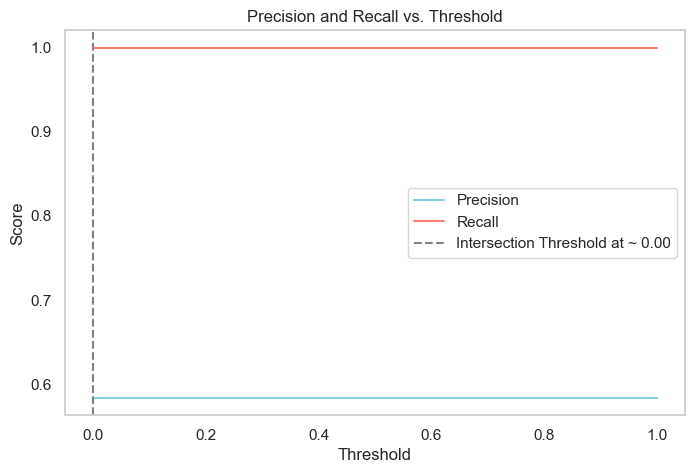

In [51]:
# Precision and Recall plot
plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_scores, x="threshold", y="precision", label="Precision", color="skyblue"
)

sns.lineplot(data=df_scores, x="threshold", y="recall", label="Recall", color="salmon")

plt.axvline(
    x=intersection_threshold,
    color="gray",
    linestyle="--",
    label=f"Intersection Threshold at ~ {intersection_threshold:.2f}",
)

plt.grid(False)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")

plt.legend()
plt.show()

In [52]:
df_scores["f1_score"] = (
    2
    * (df_scores.precision * df_scores.recall)
    / (df_scores.precision + df_scores.recall)
)

best_f1_threshold = df_scores.iloc[np.argmax(df_scores.f1_score)]["threshold"]

print(f"The best threshold based on F1 score is: {best_f1_threshold:.3f}")

The best threshold based on F1 score is: 0.000


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [53]:
# Initialize k-fold for cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

# Cross Validation
for train_idx, val_idx in kfold.split(full_train_df):
    # Create train and validation sets for this fold
    df_train_fold = full_train_df.iloc[train_idx]
    df_val_fold = full_train_df.iloc[val_idx]

    # Get the target variable
    y_train_fold = df_train_fold[target].to_numpy()
    y_val_fold = df_val_fold[target].to_numpy()

    # One-hot enconding
    # Initialize and Fit the vectorizer
    dv_fold = DictVectorizer(sparse=False)

    X_train_fold = dv_fold.fit_transform(
        df_train_fold[features].to_dict(orient="records")
    )

    # Transform the validation data using the fitted vectorizer
    X_val_fold = dv_fold.transform(df_val_fold[features].to_dict(orient="records"))

    # Train the model
    model_fold = LogisticRegression(solver="liblinear", C=1.0, max_iter=1_000)
    model_fold.fit(X_train_fold, y_train_fold)

    # Get predictions and calculate AUC
    y_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc)

In [55]:
# Calculate the Standard Deviation of AUC
std_auc = np.std(auc_scores)

print(f"AUC scores per fold: {[round(s, 3) for s in auc_scores]}")
print(f"Standard Deviation: {std_auc:.3f}")

AUC scores per fold: [0.806, 0.871, 0.775, 0.802, 0.856]
Standard Deviation: 0.036


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

In [56]:
C_values = [0.000001, 0.001, 1.0]

# Initialize k-fold for cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

cv_results = {}

for C in C_values:
    auc_scores_fold = []

    # Cross Validation
    for train_idx, val_idx in kfold.split(full_train_df):
        # Create train and validation sets for this fold
        df_train_fold = full_train_df.iloc[train_idx]
        df_val_fold = full_train_df.iloc[val_idx]

        # Get the target variable
        y_train_fold = df_train_fold[target].to_numpy()
        y_val_fold = df_val_fold[target].to_numpy()

        # One-hot enconding
        # Initialize and Fit the vectorizer
        dv_fold = DictVectorizer(sparse=False)

        X_train_fold = dv_fold.fit_transform(
            df_train_fold[features].to_dict(orient="records")
        )

        # Transform the validation data using the fitted vectorizer
        X_val_fold = dv_fold.transform(df_val_fold[features].to_dict(orient="records"))

        # Train the model
        model_fold = LogisticRegression(solver="liblinear", C=C, max_iter=1_000)
        model_fold.fit(X_train_fold, y_train_fold)

        # Get predictions and calculate AUC
        y_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        auc_scores_fold.append(auc)

    # Calculate mean and std for this C
    mean_auc = np.mean(auc_scores_fold)
    std_auc = np.std(auc_scores_fold)

    cv_results[C] = {"mean_auc": mean_auc, "std_auc": std_auc}

    print(f"C = {C:<8.6f} | Mean AUC: {mean_auc:.3f} | Std: {std_auc:.3f}")

C = 0.000001 | Mean AUC: 0.560 | Std: 0.024
C = 0.001000 | Mean AUC: 0.867 | Std: 0.029
C = 1.000000 | Mean AUC: 0.822 | Std: 0.036


In [57]:
best_C = None
best_mean_auc = -1
best_std = float("inf")

for C, scores in cv_results.items():
    mean_auc = scores["mean_auc"]
    std_auc = scores["std_auc"]

    if mean_auc > best_mean_auc:
        best_mean_auc = mean_auc
        best_std = std_auc
        best_C = C
    elif mean_auc == best_mean_auc:
        if std_auc < best_std:  # Tie-breaker: lower std
            best_std = std_auc
            best_C = C

print(f"\nBest C value: {best_C}")


Best C value: 0.001


In [58]:
print(
    f"The best C is: {best_C} with a mean AUC of {cv_results[best_C]['mean_auc']:.3f} and std of {cv_results[best_C]['std_auc']:.3f}"
)

The best C is: 0.001 with a mean AUC of 0.867 and std of 0.029
